In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import alphashape
import scanpy as sc
import pandas as pd

In [3]:
%matplotlib inline

figure_params = {
    'dpi': 300, 
    'bbox_inches': 'tight', 
    'format': 'svg', 
    'transparent': True
}

plt.rcParams.update({
    "text.usetex": False,
    "svg.fonttype": 'none'
})

In [4]:
# Human Tonsil snRNAseq from SlideTags
# https://www.nature.com/articles/s41586-023-06837-4

adata = sc.read_h5ad('../data/snrna_germinal_center.h5ad')
adata

AnnData object with n_obs × n_vars = 1309 × 3333
    obs: 'cell_type', 'cell_type_2', 'cell_type_int', 'colors', 'cell_type_major'
    obsm: 'X_umap', 'spatial'
    layers: 'raw_count'

In [5]:
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150


ct_points_wt = {}
for ct in adata.obs['cell_type_major'].unique():
    points = np.asarray(
        adata[adata.obs['cell_type_major'] == ct].obsm['spatial'])
    delta = 30
    points = np.vstack(
        (points +[-delta,delta], points +[-delta,-delta], 
        points +[delta,delta], points +[delta,-delta]))
    ct_points_wt[ct] = points

In [6]:
color_dict = dict(adata.obs[['cell_type_2', 'colors']].drop_duplicates().values)

In [7]:
%matplotlib inline

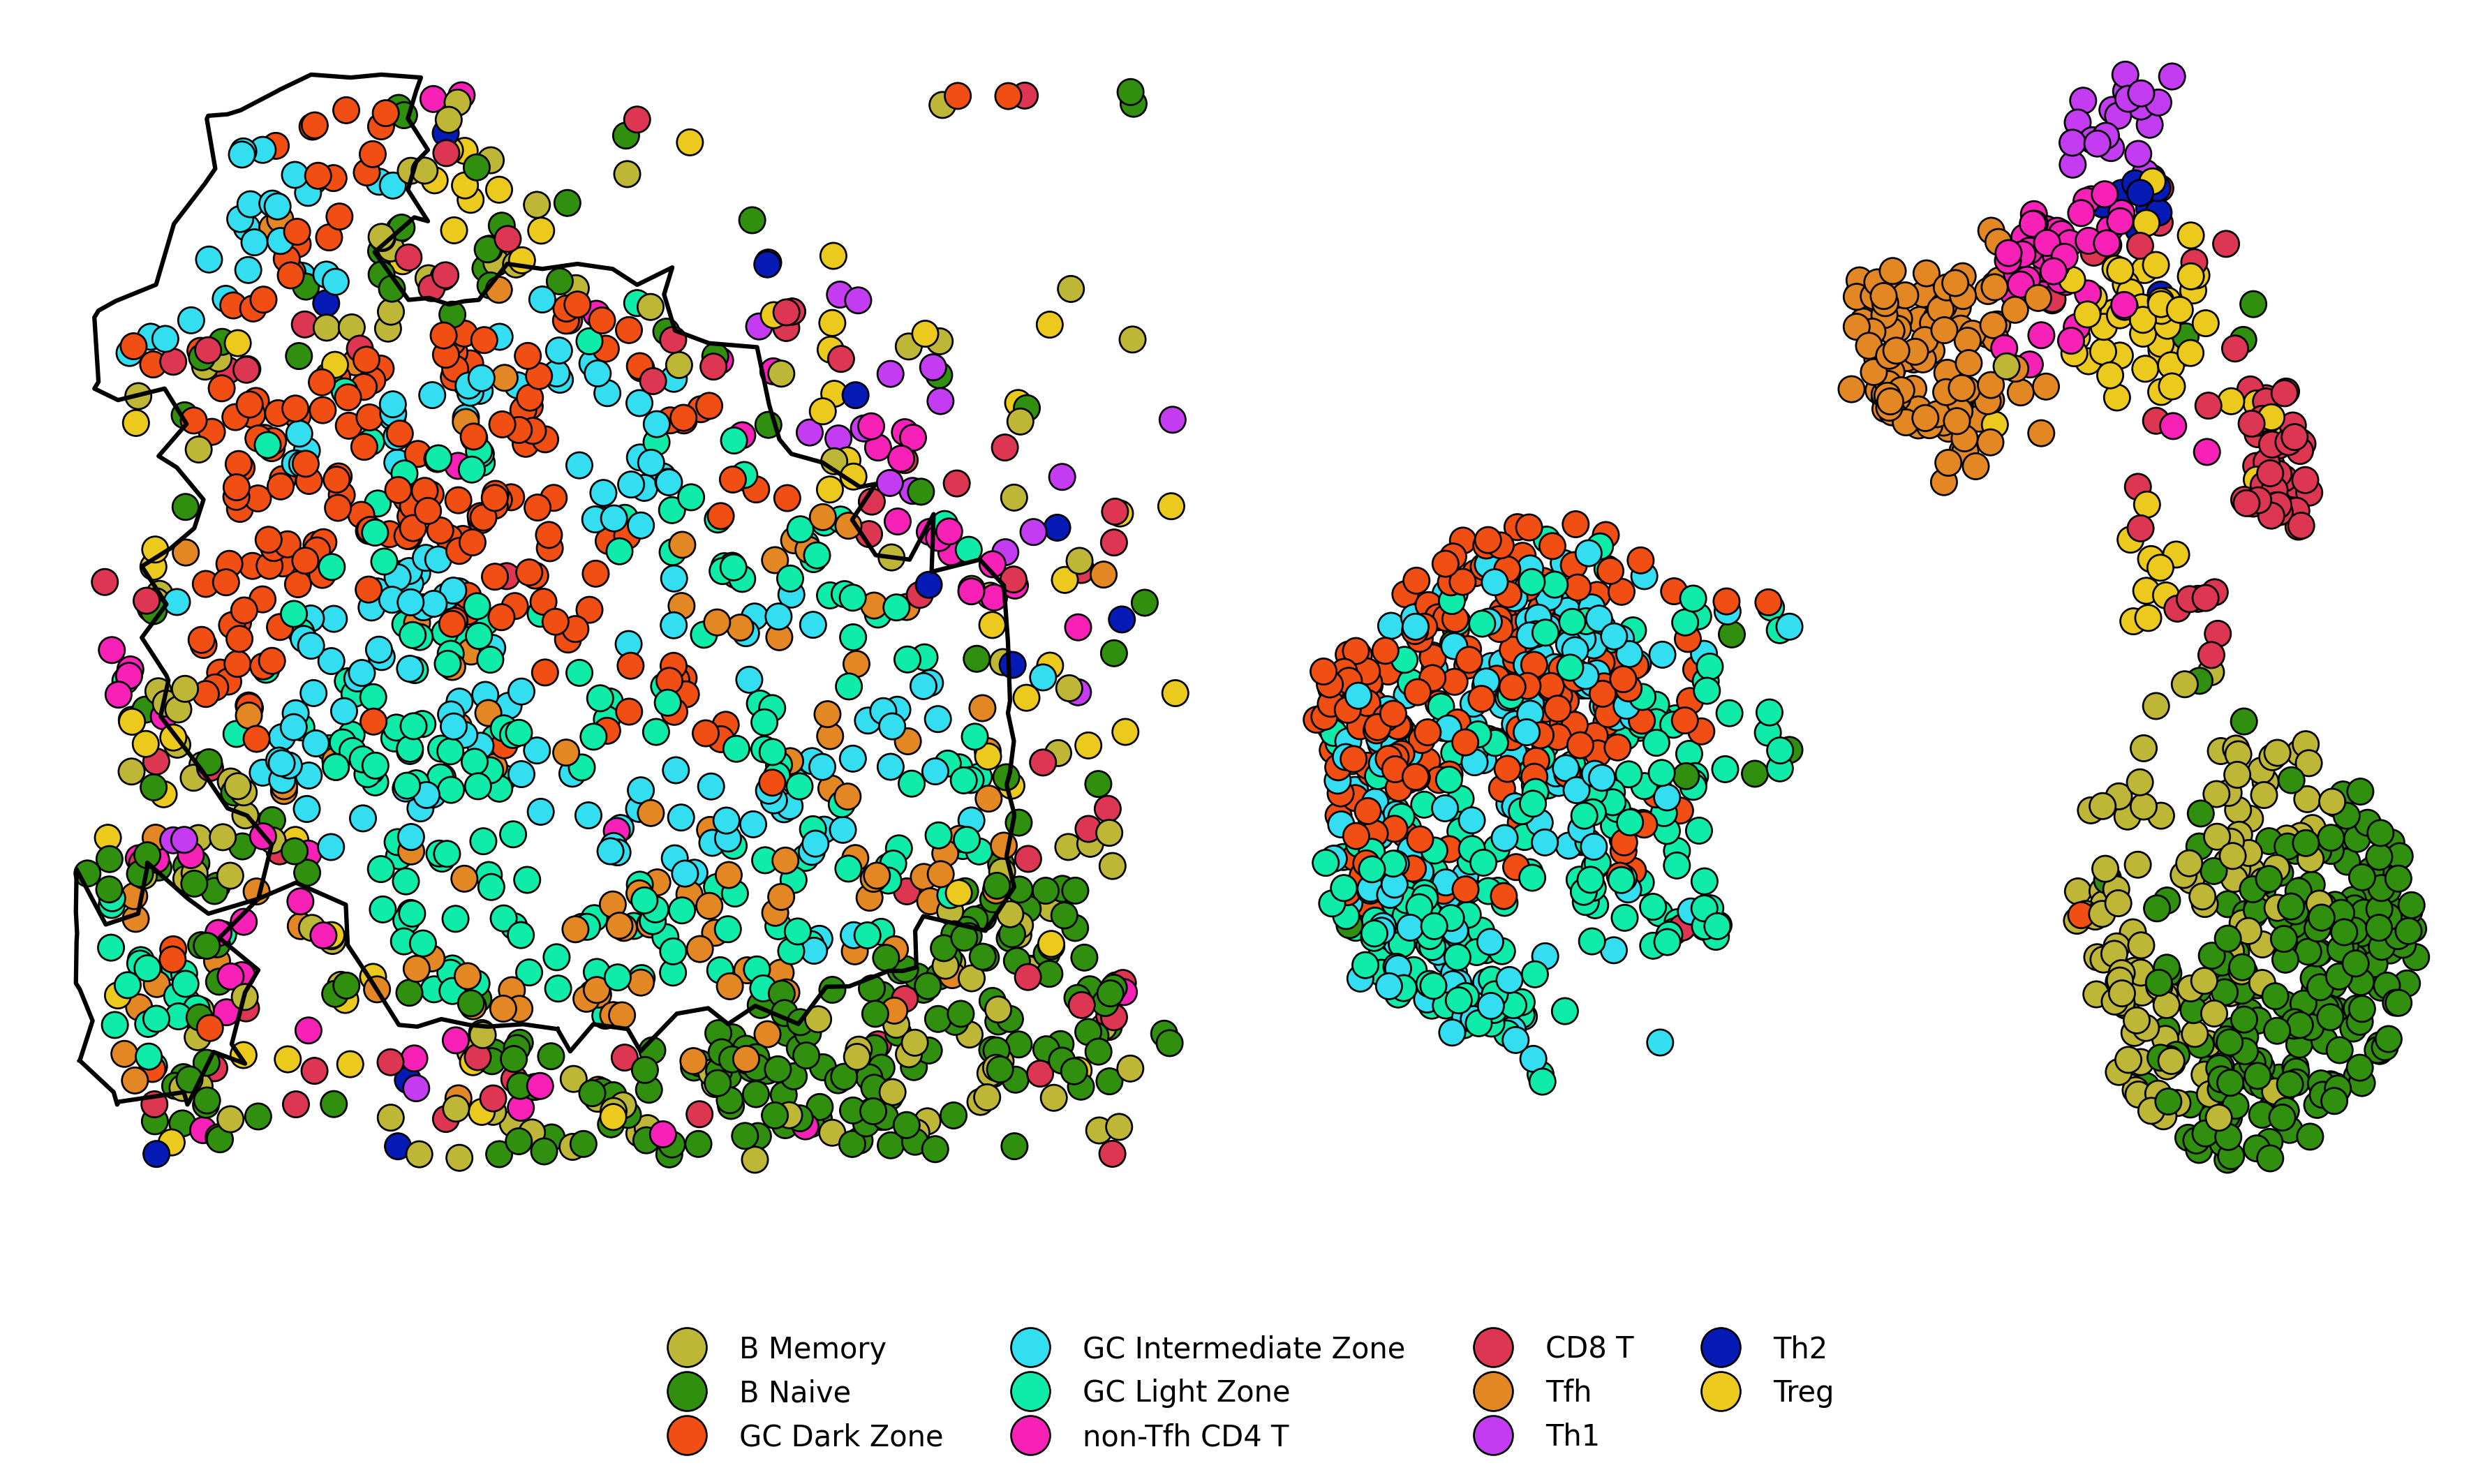

In [8]:
annot = 'cell_type_2'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=adata.obs, 
    x=adata.obsm['spatial'][:,0], 
    y=adata.obsm['spatial'][:,1],
    s=80,
    hue=annot,
    linewidth=0.65,
    edgecolor='black',
    legend='brief', 
    palette=color_dict,
    ax=ax1
)

ax1.axis('off')

alpha_shape = alphashape.alphashape(
    ct_points_wt['Germinal Center B cells'], alpha=0.035)
for geom in alpha_shape.geoms:
    if geom.area > 10000:
        ax1.plot(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color='black', alpha=1
        )

sns.scatterplot(data=adata.obs, 
    x=adata.obsm['X_umap'][:,0], 
    y=adata.obsm['X_umap'][:,1],
    s=80,
    hue='cell_type_2',
    linewidth=0.65,
    edgecolor='black',
    legend=False, 
    palette=color_dict,
    ax=ax2
)
ax2.axis('off')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels,
    bbox_to_anchor=(0.5, -0.05), 
    loc='upper center', 
    ncol=4, 
    frameon=False, 
    markerscale=1.5, 
    fontsize=10
)

ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()

plt.tight_layout()
plt.show()

In [15]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src')

In [16]:
from SpaceTravLR.spaceship import SpaceShip

In [ ]:
# Note: Make sure the outdir matches the one in the launch.py file

spacetravlr = SpaceShip(
    name='myTonsil', 
    # outdir='/tmp/output'
    outdir='/ocean/projects/cis240075p/awang22/output_test'
)

In [ ]:
spacetravlr.setup_(adata, overwrite=True)

In [ ]:
assert spacetravlr.is_everything_ok()

We're going on a trip in our favorite rocket ship 🚀️


In [ ]:
## Run this multiple times to spawn parallel workers
spacetravlr.spawn_worker(
    partition='GPU-shared',
    clusters='bridges2',
    gres='gpu:1',
    job_name='SpaceTravLR',
    lifespan=3, ##days
    python_path='/jet/home/awang22/.conda/envs/sheep/bin/python'
) 

Submitted batch job 35933180 on cluster bridges2

